# AC209B Final Project
## Module E: Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

- [Introduction](#introduction)
- [Data Summary](#data_summary) 
- [Exploratory Data Analysis](#eda) 
- [Model Selection and Architecture](#model_selection)
- [Results](#results)
- [Appendix I: Data Collection and Cleaning](#data_collection)  
    - [COVID-19 Cases by State](#us_state_covid)  
    - [Google Search Data](#google_search)  
    - [Google Community Mobility Reports](#google_mobility)  
    - [IHME Social Distancing Data](#ihme_social_distancing)
    
 

<a id='introduction'></a>
## Introduction
***

In late 2019, a highly infectious novel coronavirus (SARS-CoV-2) emerged in the city of Wuhan, China. Within weeks, the virus and the disease it causes (COVID-19) had spread to multiple countries. On March 11, 2020, the World Health Organization officially declared the COVID-19 outbreak a pandemic, and as of the end of April 2020, there were over 3 million COVID-19 cases worldwide across over 200 countries and territories.

This project focuses on the impact of COVID-19 in the United States. In particular, we use a combination of Google search and mobility data, weather data, hospitalization and ICU numbers, and the dates in which state social distancing measures took effect to predict state-level COVID-19 cases in the US.

In [1]:
import pandas as pd
import pickle
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


<a id='data_summary'></a>
## Data Summary
***

For our response, we used a state-by-state COVID-19 cases dataset, curated by the New York times:
- **[COVID-19 Cases by State (Response)](https://github.com/nytimes/covid-19-data):** The NYT publishes national, state-level, and county-level COVID-19 case data to their github repository daily

To make predictions, we leveraged the following predictor data:
- **[Google Trends Search Data](https://trends.google.com/trends/?geo=US):** Through the Google Trends API, we collected search query data related to the coronavirus, and focused in particular on coronavirus symptom-based searches
- **[Google Community Mobility Reports](https://www.google.com/covid19/mobility/data_documentation.html?hl=en):** In March of 2020, Google began publishing "Community Mobility Reports", which tracked changes in activity from a pre-coronavirus baseline to now for countries across the world. It built these reports by collecting the location data tied to cell phones. In particular, it tracked changes in mobility for the following six categories: 
    - Retail & recreation
    - Grocery & pharmacy
    - Parks
    - Transit stations
    - Workplaces
    - Residential
- **[State Social Distancing Measures](http://www.healthdata.org/covid/faqs#social%20distancing):** The University of Washington's Institute for Health Metrics and Evaluation (IHME) has produced one of the most famous COVID-19 models. As part of its modeling, it incorporates state-wide social distancing measures. We've leveraged their data to determine whether and when a state put in place the following the following measures:
    - Educational facilities closed
    - Non-essential businesses ordered to close
    - People ordered to stay at home
    - Severe travel restrictions
    - Any gathering restrictions
    - Any business closures
- **[Hospitalization and ICU Data](https://covidtracking.com/data):** The Covid Tracking Project monitors hospitalization and ICU numbers for the states that report them. However, a big caveat for this data is that many states do not report these numbers
- **[Weather Data]():** NOAA - temperature, humidity?



<a id='eda'></a>
## Exploratory Data Analysis
***
**US Cases by State**

In our initial EDA, we generated a bubble plot of the US, displaying states that were especially hard hit by COVID-19 (New York, Louisiana, and New Jersey), in terms of cases per capita. Rerunning our code depicts a grimmer picture, with new states such as Michigan and Illinois joining the originally hard hit ones.

In [44]:
from IPython.display import IFrame

IFrame(src='./images/US_covid_map.html', width=700, height=600)

**Community Reports**

We also looked at community mobility reports. It might be worth looking at how mobility has changed over time since our initial EDA. As we can see below, after the precipitous drop in early April, retail and recreation have begun to slightly increase again, especially in Georgia, which, on May 1st, canceled its stay at home order. A similar trend is present in transit stations and workplaces.

In [67]:
# load mobility reports
mobility_us = pickle.load( open( "./data/us_state_mobility_data.p", "rb" ) )
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


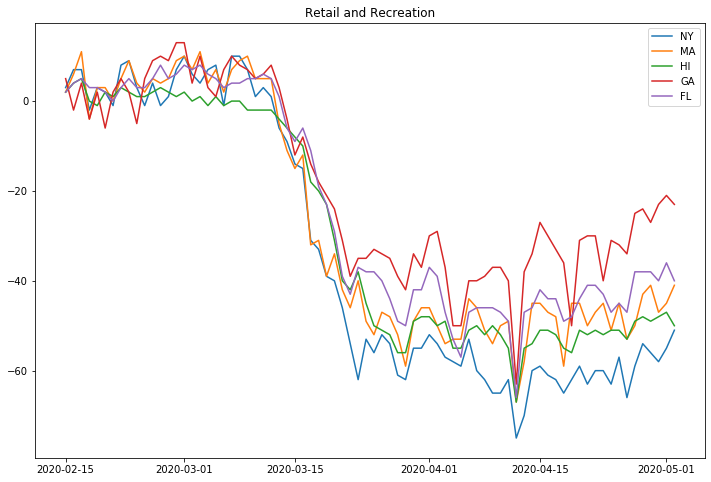

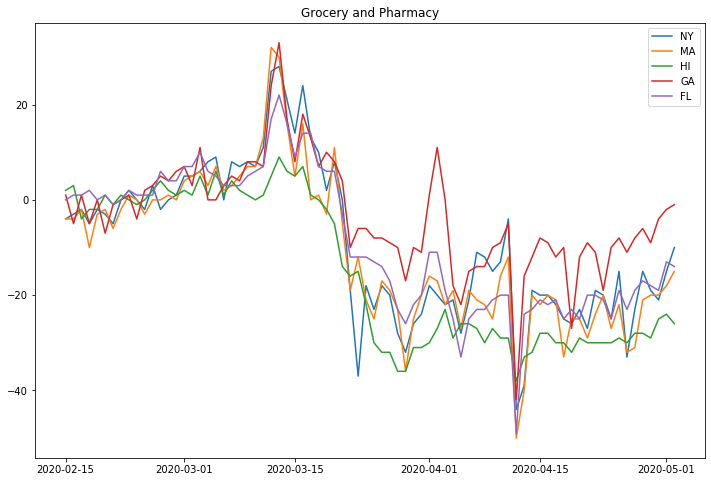

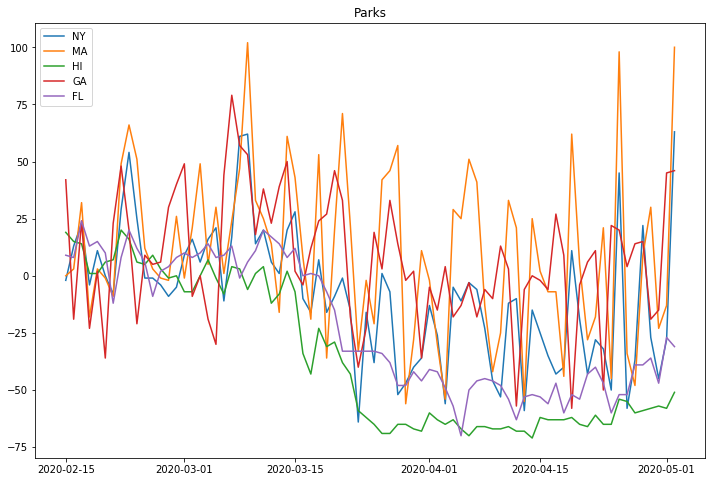

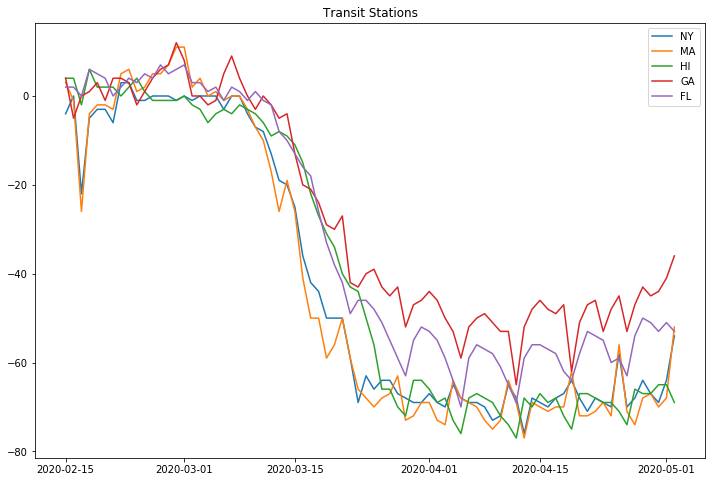

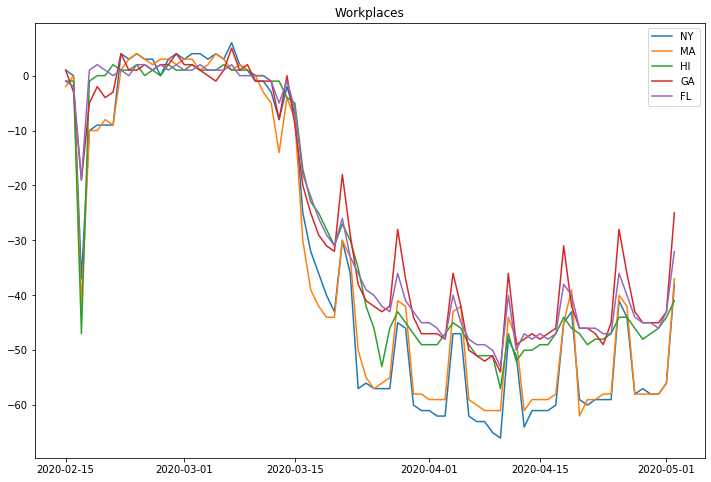

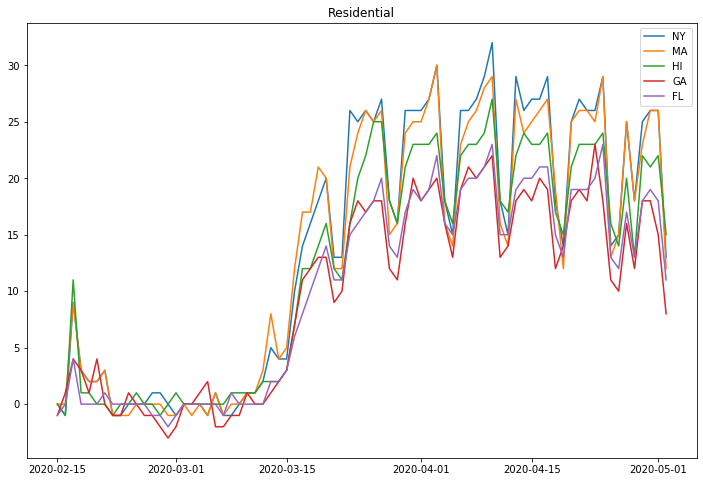

In [69]:
# subset of a few states
states = ["NY", "MA", "HI", "GA", "FL"]
mobility_sub = mobility_us.loc[mobility_us["abbrev"].isin(states)]


# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "retail_and_recreation_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Retail and Recreation")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "grocery_and_pharmacy_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Grocery and Pharmacy")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "parks_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Parks")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "transit_stations_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Transit Stations")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "workplaces_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Workplaces")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "residential_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Residential")
    plt.legend();

**Coronavirus-Related Queries**


<a id='model_selection'></a>
## Model Selection and Architecture
***

<a id='results'></a>
## Results
***

<a id='data_collection'></a>
## Appendix I: Data Collection and Cleaning
***

<a id='us_state_covid'></a>
### COVID-19 Cases by State
We'll start by fetching and cleaning our response data: COVID-19 cases by state

In [11]:
# fetch US state data from the NY Times github
covid_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")

# fetch US totals data and match formatting
covid_us_totals = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")
covid_us_totals["state"] = "United States"
covid_us_totals["fips"] = 0
covid_us_totals = covid_us_totals[["date", "state", "fips", "cases", "deaths"]]

# merge two dfs
covid_us = pd.concat([covid_us, covid_us_totals])

# transform date to datetime object
covid_us["date"] = pd.to_datetime(covid_us["date"])

covid_us

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
104,2020-05-04,United States,0,1186979,68843
105,2020-05-05,United States,0,1210686,71077
106,2020-05-06,United States,0,1235190,73785
107,2020-05-07,United States,0,1264001,75744


In [33]:
def impute_missing_dates(df):
    '''
    function that imputes cases and deaths data for missing 
    dates with 0. returned df should have same MIN_DATE and 
    MAX_DATE for all states.
    '''
    # set min values
    MIN_DATE = df["date"].min()
    MIN_CASES = 0
    MIN_DEATHS = 0
    
    # iterate through all states
    imputed_data = []    
    for state in df["state"].unique():
        # build list of missing dates
        # https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
        sdate = MIN_DATE
        edate = df.loc[df["state"] == state]["date"].min()
        delta = edate - sdate 

        # iterate through all missing dates and impute case and 
        # death data
        for i in range(delta.days):
            day = sdate + datetime.timedelta(days=i)
            imputed_data.append({"date": day,
                                 "state": state,
                                 "fips": df.loc[df["state"]==state].iloc[0]["fips"],
                                 "cases": MIN_CASES,
                                 "deaths": MIN_DEATHS})

    # final cleanup
    new_df = pd.concat([pd.DataFrame(imputed_data), df])
    new_df = new_df.sort_values(by=["state", "date"]).reset_index().drop("index", axis=1)
    
    return new_df
    

def days_since_20200101(df):
    '''
    Creates a new column which measures the number of days that 
    a given observation is from 20200101 (which will be our 
    baseline date)
    '''
    # create days_since_20200101 col
    START_DATE = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
    df["days_since_20200101"] = (df["date"] - START_DATE).dt.days
    
    return df
    
    
# map state abbreviation
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'United States': 'USA'
}

states = list(states_dict.values())

In [13]:
# clean data by imputing missing dates and mapping abbreviations
covid_us_cleaned = impute_missing_dates(covid_us)
covid_us_cleaned["abbrev"] = covid_us_cleaned["state"].map(states_dict)

# create days_since_20200101 col
covid_us_cleaned = days_since_20200101(covid_us_cleaned)
covid_us_cleaned

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24
...,...,...,...,...,...,...,...
6099,2020-05-04,Wyoming,56,596,7,WY,124
6100,2020-05-05,Wyoming,56,604,7,WY,125
6101,2020-05-06,Wyoming,56,631,7,WY,126
6102,2020-05-07,Wyoming,56,635,7,WY,127


<a id='google_search'></a>
### Google COVID-19 Searches

Next, we collected Google search data related to COVID-19. We started by curating a list of Google search queries that we thought could be predictive of coronavirus cases. To extract the Google query data, we used [pytrends](https://github.com/GeneralMills/pytrends) a library that allows you to query the GoogleTrends API for search data.

In [14]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

We started by fetching a list of queries related to "coronavirus symptoms"

In [15]:
kw_list = ["coronavirus symptoms"]
now = datetime.datetime.now().strftime("%Y-%m-%d")
time_frame = f'''2020-01-01 {now}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
pyt.related_queries()[kw_list[0]]["rising"]

,query,value
0,the coronavirus,989350
1,the symptoms of the coronavirus,675550
2,the symptoms of coronavirus,663400
3,corona symptoms,490450
4,corona,488550
5,what are coronavirus symptoms,413900
6,corona virus,354150
7,corona virus symptoms,345900
8,what are symptoms of coronavirus,343550
9,what are the coronavirus symptoms,325700


The final query list we landed on was:
- 'flu'
- 'shortness of breath'
- 'loss of smell'
- 'loss of taste'
- 'cough'
- 'fever'
- 'coronavirus testing near me'
- 'do i have coronavirus'
- 'covid testing center'
- 'chills'
- 'sore throat'
- 'fatigue'
- 'chest pain'

Note: the Google Trends API only allows you to compare 5 queries at a time. Thus, we used our highest volume query, `flu`, and included it in several calls as a baseline.

In [ ]:
def fetch_query_data(kw_list):
    '''
    Fetches Google search data for a list of keywords
    for all states, one at a time. We do it one at a time
    so that the search data is relative to the timing of 
    each state
    '''
    
    # instantiate state list and empty df to store results
    states = list(states_dict.values())
    state_queries = pd.DataFrame(columns = ["date", "abbrev"] + kw_list)
    state_queries = state_queries.set_index("date")

    print(f"Fetching data for the following queries: {kw_list}")
    # fetch all queries for each state in date range
    for state in states:
        if state == "USA":
            geo = "US"
        else:
            geo = f"US-{state}"
        try:
            pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo=geo, gprop='')
        except:
            print(f"NOT FOUND: {state}")
            continue
        interest = pyt.interest_over_time().reset_index()
        interest["abbrev"] = state
        state_queries = pd.concat([interest, state_queries])

    # clean data types
    state_queries["date"] = pd.to_datetime(state_queries["date"])
    state_queries[kw_list] = state_queries[kw_list].apply(pd.to_numeric)
    state_queries = state_queries[["date", "abbrev"] + kw_list]
    
    # sort
    state_queries = state_queries.sort_values(by=["abbrev", "date"])
    
    return(state_queries)

In [ ]:
# build queries 5 at a time, benchmark is flu
# start queries
benchmark = "flu"
kw_list = [benchmark, "shortness of breath", "loss of smell", "loss of taste", "cough"]
queries_master = fetch_query_data(kw_list)

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "fever", "coronavirus testing near me", "do i have coronavirus", 
           "covid testing center"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "chills", "sore throat", "fatigue", "chest pain"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])



<a id='google_mobility'></a>
### Google Community Mobility Reports

In [26]:
# load mobility reports
mobility = pd.read_csv("./data/raw_data/Global_Mobility_Report.csv")
mobility.head()


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [27]:
# US data - condense to state level
mobility_us = mobility.loc[(mobility["country_region_code"] == "US") & (pd.isnull(mobility["sub_region_2"]))]

# subset columns
mobility_us = mobility_us[["date", "sub_region_1", "retail_and_recreation_percent_change_from_baseline", 
                           "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline",
                           "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline",
                           "residential_percent_change_from_baseline"]]

# rename state column
mobility_us = mobility_us.rename({'sub_region_1': 'state'}, axis=1)

# fetch abbrevation
mobility_us["abbrev"] = mobility_us["state"].map(states_dict)

# fill USA totals with appropriate labels
mobility_us["state"] = mobility_us["state"].fillna(value="United States")
mobility_us["abbrev"] = mobility_us["abbrev"].fillna(value="USA")

# convert date to datetime obj
mobility_us["date"] = pd.to_datetime(mobility_us["date"])

mobility_us.head()


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA


In [28]:
# add days since 20200101
mobility_us = days_since_20200101(mobility_us)
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


<a id='ihme_social_distancing'></a>
### IHME: social distancing measures

The following [mitigation/social distancing](http://www.healthdata.org/covid/faqs#social%20distancing) measures were collected by IHME and incoporated into their model:

- **Educational facilities closed:** All levels of educational instruction (primary, secondary, and higher education) are required to implement distance learning and are closed for in-person teaching activities.
 
- **Non-essential businesses ordered to close:** Only locally defined “essential services” are in operation. Typically, this results in closure of public spaces such as stadiums, cinemas, shopping malls, museums, and playgrounds. It also includes restrictions on bars and restaurants (they may provide take-away and delivery services only), closure of general retail stores, and services (like nail salons, hair salons, and barber shops) where appropriate social distancing measures are not practical. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **People ordered to stay at home:** All individuals are ordered to stay at home unless traveling to essential services. Physical contact is only allowed between residents of the same household. Exercise may be permitted, as a solitary, distanced exercise, or with members of the same household. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **Severe travel restrictions:** Location borders are closed to all incoming traffic except for those in provision of essential services and returning residents isolated in foreign territories. Automobile travel is restricted to accessing and working at essential services. Public transit is closed.
 
- **Any gathering restrictions:** Mandatory restrictions on gatherings of individuals of any number are in place. These can apply to public and private gatherings.
 
- **Any business closures:** The mandatory closure of any businesses is in effect. These restrictions need not apply to all businesses but can apply to just a specific subset (like bars and restaurants)


For our purposes, we took the measure start/end dates and transformed them into a time series for each state, with a `1` indicating that a measure was in place for that date, and a `0` indicating that it was not. Here are some definitions for how we dealt with special cases:
- *Measure never activated:* IHME designates measures that never were enforced in a given state with a NULL for that measure's start date. We represented these cases with values of `0` for all dates
- *Measure doesn't have an end date:* Some measures that have been put in place do not have an end date. For those cases, IHME assumes an end date of `2020-08-04`. We did the same. That is, the measure will have a `1` for all days until `2020-08-04`. In our case, the master dataset only extended to `2020-05-04`, so we stopped there



In [29]:
# load ihme data
ihme_summary = pd.read_csv("./data/raw_data/summary_stats_all_locs.csv")

# fetch only US states
ihme_summary = ihme_summary.loc[ihme_summary["location_name"].isin(list(states_dict.keys()))]
ihme_summary.head()

,location_name,peak_bed_day_lower,peak_bed_day_upper,peak_icu_bed_day_lower,peak_icu_bed_day_upper,peak_vent_day_lower,peak_vent_day_upper,peak_bed_day_mean,peak_icu_bed_day_mean,peak_vent_day_mean,...,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date
1,Alabama,2020-04-28,2020-07-06,2020-04-28,2020-07-05,2020-04-28,2020-07-04,2020-06-25,2020-06-26,2020-06-26,...,2020-03-19,2020-03-19,2020-04-04,NaN,2020-04-30,NaN,NaN,NaN,2020-04-30,NaN
2,Alaska,2020-04-02,2020-04-02,2020-04-05,2020-04-05,2020-04-05,2020-04-05,2020-04-02,2020-04-05,2020-04-05,...,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,NaN,NaN,NaN,2020-04-24,2020-04-24
6,Arizona,2020-04-18,2020-05-26,2020-04-19,2020-05-27,2020-04-19,2020-05-26,2020-05-05,2020-05-10,2020-05-08,...,2020-03-30,2020-03-16,2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arkansas,2020-04-26,2020-06-04,2020-04-27,2020-06-05,2020-04-27,2020-06-05,2020-04-30,2020-05-06,2020-04-29,...,2020-03-27,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,California,2020-04-19,2020-05-14,2020-04-23,2020-05-13,2020-04-22,2020-05-13,2020-04-30,2020-04-30,2020-04-30,...,2020-03-11,2020-03-19,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# create dataframe with just mitigation measures
keeps = ['location_name', 'all_non-ess_business_start_date', 'any_business_start_date',
              'any_gathering_restrict_start_date', 'educational_fac_start_date',
              'stay_home_start_date', 'travel_limit_start_date',
              'all_non-ess_business_end_date', 'any_business_end_date',
              'any_gathering_restrict_end_date', 'educational_fac_end_date',
              'stay_home_end_date', 'travel_limit_end_date']
mitigation = ihme_summary[keeps]

# per IHME, if a mitigation order has a start date, but no end date, we will
# assume that it is carried through aug 4
ASSUMED_END_DATE = "2020-08-04"
mitigation_measures = ["all_non-ess_business", "any_business", "any_gathering_restrict", "educational_fac",
                       "stay_home", "travel_limit"]

# clean state label fields
mitigation = mitigation.rename({'location_name': 'state'}, axis=1)
mitigation["abbrev"] = mitigation["state"].map(states_dict)

# impute IHME assumed end dates
for measure in mitigation_measures:
    mitigation.loc[(pd.notnull(mitigation[f"{measure}_start_date"])) & 
               (pd.isnull(mitigation[f"{measure}_end_date"]))
               , f"{measure}_end_date"] = ASSUMED_END_DATE

# convert dates to datetime
mitigation[keeps[1:]] = pd.to_datetime(mitigation[keeps[1:]].stack(), errors="coerce").unstack()
display(mitigation.head())


,state,all_non-ess_business_start_date,any_business_start_date,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date,abbrev
1,Alabama,2020-03-28,2020-03-19,2020-03-19,2020-03-19,2020-04-04,NaT,2020-04-30,2020-08-04,2020-08-04,2020-08-04,2020-04-30,NaT,AL
2,Alaska,2020-03-28,2020-03-17,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,2020-08-04,2020-08-04,2020-08-04,2020-04-24,2020-04-24,AK
6,Arizona,NaT,NaT,2020-03-30,2020-03-16,2020-03-30,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,AZ
7,Arkansas,NaT,2020-03-19,2020-03-27,2020-03-17,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,NaT,AR
22,California,2020-03-19,2020-03-19,2020-03-11,2020-03-19,2020-03-19,NaT,2020-08-04,2020-08-04,2020-08-04,2020-08-04,2020-08-04,NaT,CA


In [31]:
def build_mitigation_time_series(state_abbrev):
    '''
    Takes a start and end date for a given measure and converts it
    to a time series of 0 and 1 indicating whether the measure was
    in place for that day
    '''
    
    # build standalone df of state mitigation dates
    state_mitigation = mitigation.loc[mitigation["abbrev"] == state_abbrev]

    # empty df with state and dates of interest
    state_dates = queries_master.loc[queries_master["abbrev"] == state_abbrev][["date", "abbrev"]]
    state_dates["date"] = pd.to_datetime(state_dates["date"])

    # generate time series of mitigation measures
    for measure in mitigation_measures:
        state_dates[measure] = (
            (state_dates["date"] >= state_mitigation[f"{measure}_start_date"].values[0]) & 
            (state_dates["date"] <= state_mitigation[f"{measure}_end_date"].values[0])).astype(int)
        
    return state_dates

In [34]:
# empty df
hi = build_mitigation_time_series("HI")
state_mitigation_measures = pd.DataFrame(columns = hi.columns)

# loop through all states
for state in states:
    try:
        state_mit = build_mitigation_time_series(state)
    except:
        print(f"NOT FOUND: {state}")
    state_mitigation_measures = pd.concat([state_mitigation_measures, state_mit])
    
state_mitigation_measures.head()    

NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: VI
NOT FOUND: USA


,date,abbrev,all_non-ess_business,any_business,any_gathering_restrict,educational_fac,stay_home,travel_limit
125,2020-01-01,AL,0,0,0,0,0,0
126,2020-01-02,AL,0,0,0,0,0,0
127,2020-01-03,AL,0,0,0,0,0,0
128,2020-01-04,AL,0,0,0,0,0,0
129,2020-01-05,AL,0,0,0,0,0,0
